In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Carregar MNIST
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalização
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    return x_train, y_train, x_test, y_test

In [4]:
# Carregar modelo gerador cGAN pré-treinado
def load_cgan_generator(model_path):
    return tf.keras.models.load_model(model_path)

In [14]:
# Gerar dados sintéticos com cGAN
def generate_synthetic_data(generator, missing_classes, num_samples=100, num_classes=10):
    synthetic_data = []
    synthetic_labels = []
    noise_dim = 100  # Dimensão do ruído para o gerador
    
    for label in missing_classes:
        noise = np.random.normal(0, 1, (num_samples, noise_dim))
        labels = np.full((num_samples, 1), label)
        labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
        
        # Passar os inputs como uma lista separada
        generated_samples = generator.predict([noise, labels_one_hot])
        
        # Ajustar formato da saída caso esteja achatado
        if generated_samples.shape[1] == 4096:
            generated_samples = generated_samples.reshape((num_samples, 64, 64))  # Caso o modelo tenha saída maior
        elif generated_samples.shape[1] == 784:
            generated_samples = generated_samples.reshape((num_samples, 28, 28))  # Caso o modelo gere imagens achatadas
        else:
            raise ValueError(f"Formato inesperado da saída do gerador: {generated_samples.shape}")
        
        synthetic_data.append(generated_samples)
        synthetic_labels.append(labels)
    
    return np.concatenate(synthetic_data), np.concatenate(synthetic_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Dados sintéticos gerados: (300, 64, 64) (300, 1)


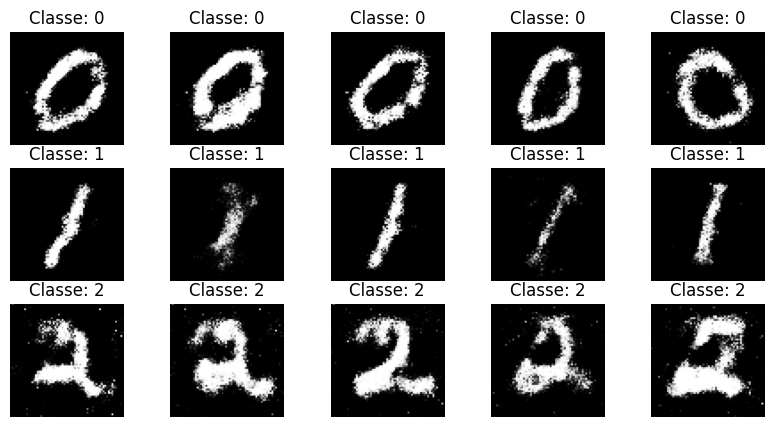

In [16]:
if __name__ == "__main__":
    x_train, y_train, x_test, y_test = load_data()
    generator = load_cgan_generator("generator_model.keras")
    
    missing_classes = [0, 1, 2]  # Suponha que essas classes estejam ausentes
    synthetic_x, synthetic_y = generate_synthetic_data(generator, missing_classes)
    
    print("Dados sintéticos gerados:", synthetic_x.shape, synthetic_y.shape)
    
    # Visualizar alguns dados sintéticos organizados por classe
    plt.figure(figsize=(10, 5))
    for idx, label in enumerate(missing_classes):
        class_samples = synthetic_x[synthetic_y.flatten() == label]
        for i in range(5):  # Mostrar 5 exemplos por classe
            plt.subplot(len(missing_classes), 5, idx * 5 + i + 1)
            plt.imshow(class_samples[i], cmap='gray')
            plt.title(f"Classe: {label}")
            plt.axis('off')
    plt.show()